# Navarro-Frank-White halo potential

In [1]:
import os
from math import pi
from autocvd import autocvd
# autocvd(num_gpus = 1)
# os.environ["CUDA_VISIBLE_DEVICES"] = "9"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial
from math import radians


import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord


import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_MATRIX, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP
from odisseo.option_classes import SimulationConfig, SimulationParams, NFWParams, MNParams, PSPParams, PlummerParams, NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot, plot_sky_projection
from odisseo.potentials import NFW, MyamotoNagai, PowerSphericalPotentialwCutoff

plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

# Plummer Sphere

In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  
# code_units = CodeUnits(code_length, code_mass, G=G)  # default values


config = SimulationConfig(N_particles = 10_000, 
                          return_snapshots = True, 
                          num_snapshots = 1_00, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)


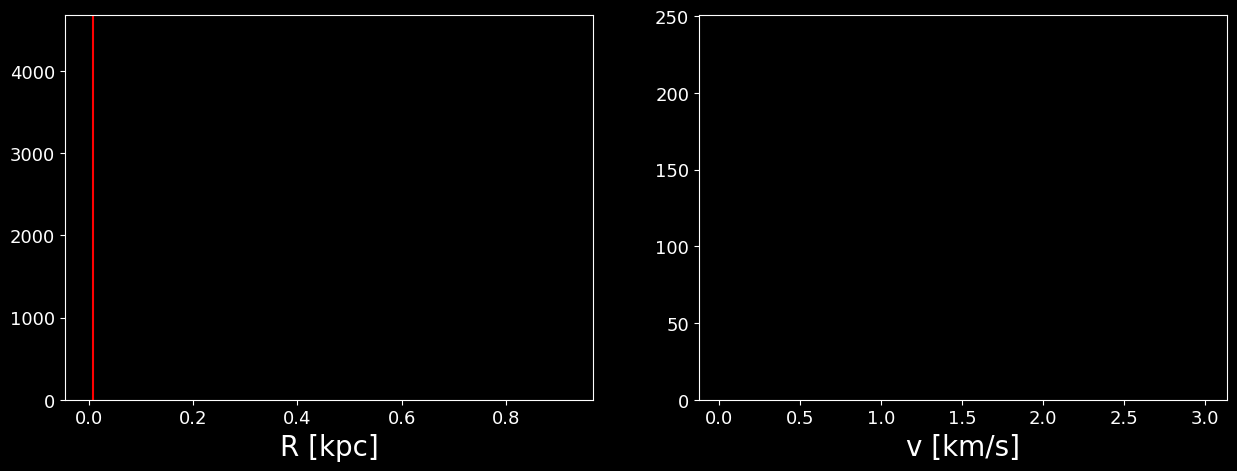

In [3]:
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)

#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()


In [4]:
#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,return_snapshots=True,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
# pos_com_final = jnp.array([[12.4, 1.5, 7.1]]) * u.kpc.to(code_units.code_length)
# vel_com_final = jnp.array([[107.0, -243.0, -105.0]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

In [15]:
args = (initial_state_stream, mass, config, params)
print(jax.jit(time_integration, static_argnums=(2, 3)).lower(*args).compile().cost_analysis())

{'bytes accessedout{27}': 240000.0, 'bytes accessedout{3}': 300359616.0, 'bytes accessed12{}': 1280000.0, 'bytes accessed17{}': 30000.0, 'bytes accessedout{30}': 240000.0, 'bytes accessedout{10}': 5310040.0, 'bytes accessed5{}': 2160047.0, 'utilization7{}': 29.0, 'utilization4{}': 52.0, 'bytes accessedout{5}': 6602016.0, 'bytes accessedout{19}': 270000.0, 'bytes accessedout{0}': 805416448.0, 'bytes accessedout{29}': 240000.0, 'flops': 6219460096.0, 'utilization15{}': 5.0, 'bytes accessedout{7}': 6480064.0, 'utilization10{}': 20.0, 'utilization13{}': 7.0, 'bytes accessedout{16}': 511600.0, 'utilization23{}': 3.0, 'utilization2{}': 78.0, 'bytes accessedout{18}': 510000.0, 'utilization30{}': 2.0, 'bytes accessed28{}': 8.0, 'utilization25{}': 2.0, 'utilization21{}': 3.0, 'bytes accessedout{25}': 240000.0, 'bytes accessed21{}': 80000.0, 'bytes accessedout{2}': 11616472.0, 'bytes accessedout{17}': 514800.0, 'bytes accessedout{21}': 270000.0, 'utilization5{}': 35.0, 'bytes accessed23{}': 8.0,

In [5]:
if config.return_snapshots: 
    snapshots = jax.block_until_ready(time_integration(initial_state_stream, mass, config, params))
else:
    final_state = jax.block_until_ready(time_integration(initial_state_stream, mass, config, params))


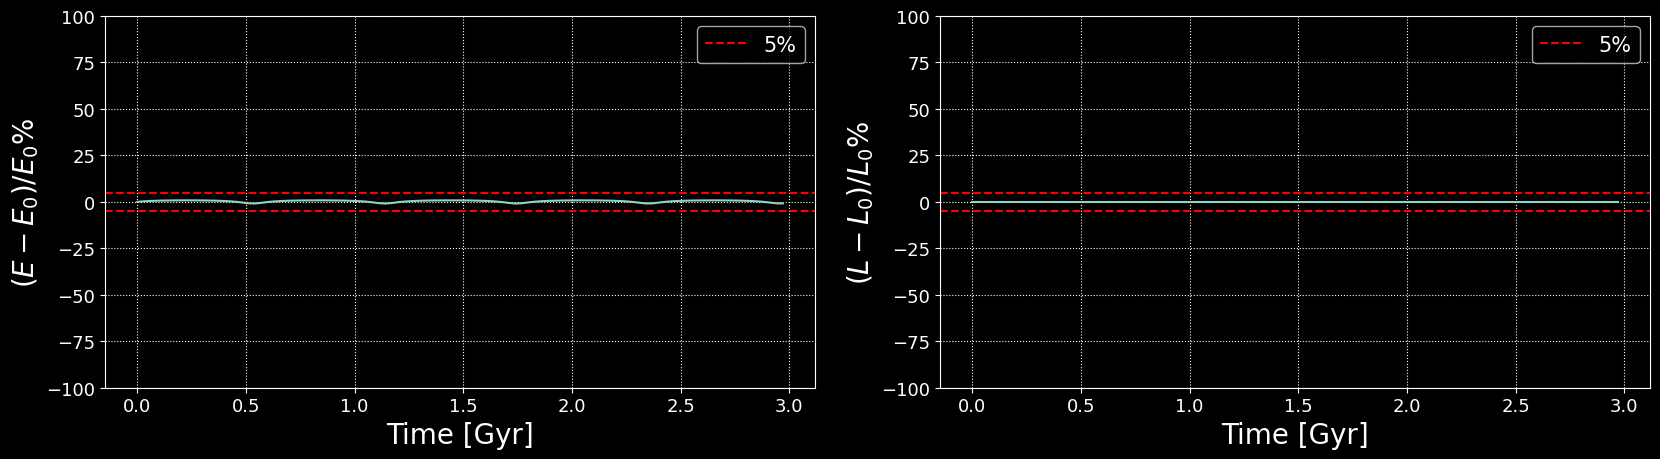

In [6]:
energy_angular_momentum_plot(snapshots, code_units, filename='./visualization/image/E_L_Plummer_in_MWpotential.pdf')

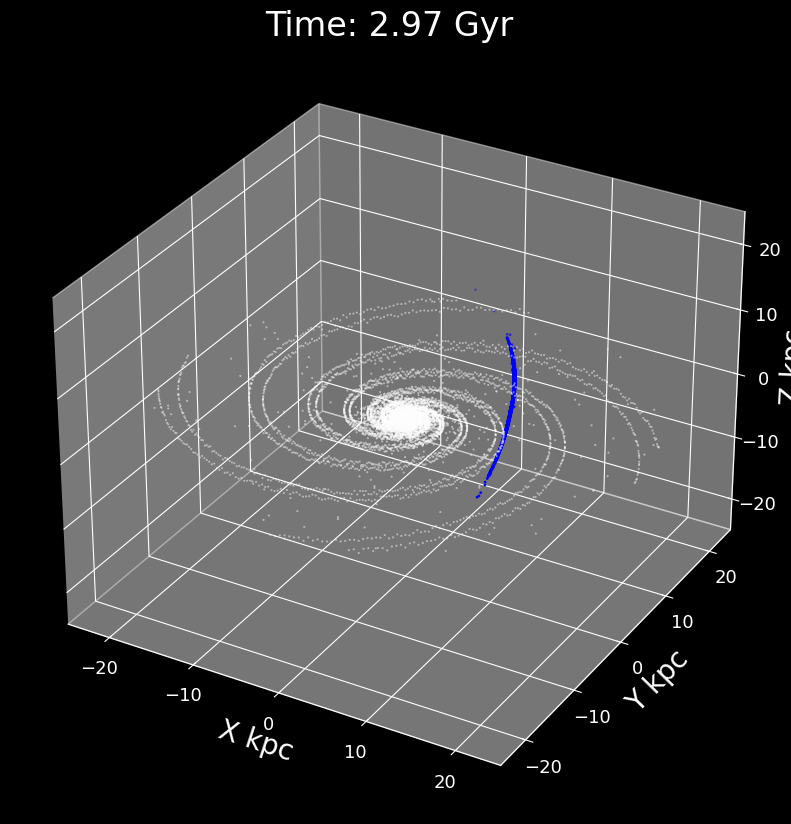

In [7]:
create_3d_gif(snapshots, 
              ax_lim=25 * u.kpc.to(code_units.code_length), 
              code_units=code_units, 
              plotting_units_length=u.kpc, 
              plot_units_time=u.Gyr, 
              filename='./visualization/gif/simulation_Plummer_in_MWpotential.gif')

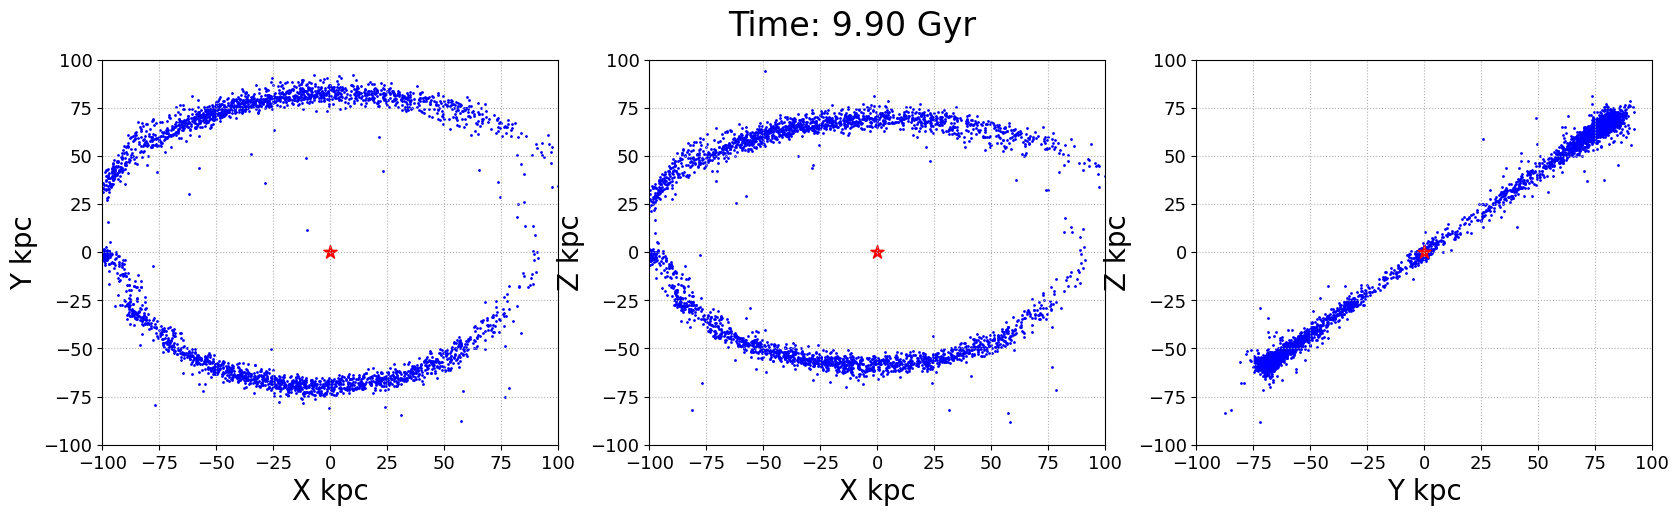

In [ ]:
create_projection_gif(snapshots=snapshots,
                      ax_lim=rp, 
                      code_units=code_units, 
                      plotting_units_length=u.kpc, 
                      plot_units_time=u.Gyr, 
                      filename='./visualization/gif/simulation_projection_Plummer_in_NFWpotential.gif')

# Projection on the sky 

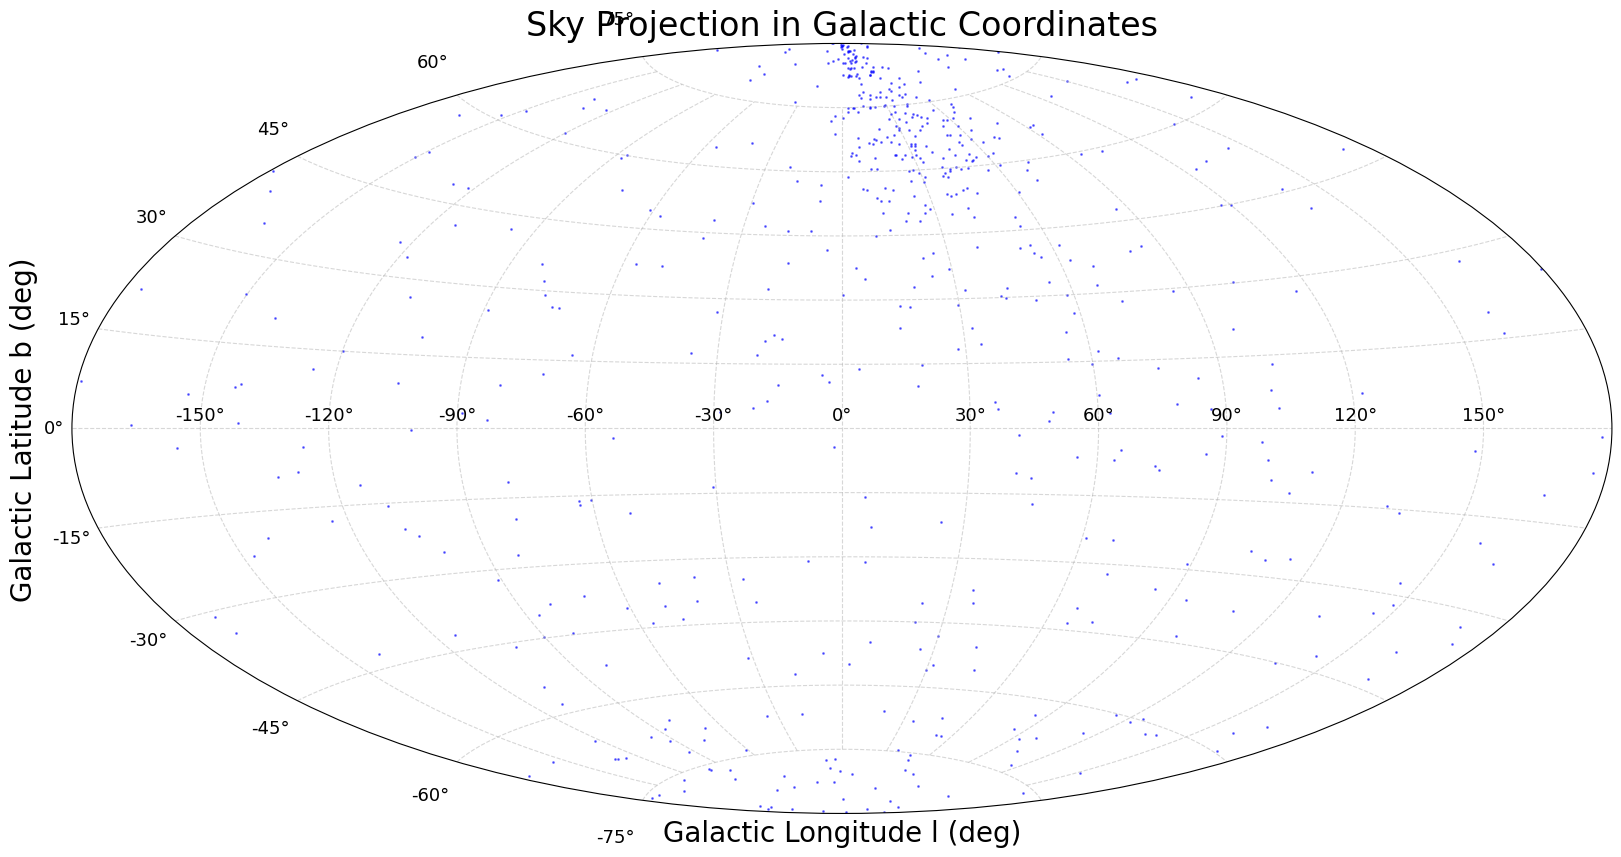

In [11]:
plot_sky_projection(snapshots=snapshots, code_units=code_units, plotting_units_length=u.kpc, filename=None)